# CALFEWS: California Food-Energy-Water System simulation model
This notebook provides an introductory tutorial for how to run the California Food-Energy Water System (CALFEWS) simulation model. The major sections are as follows:
1. Setting simulation parameters
1. Using different hydrologic inputs
1. Running the model
1. Analyzing and visualizing model output

## Setting simulation parameters
The main parameters file for CALFEWS is ``runtime_params.ini``. This file allows the user to change the type of simulation, the input data, output data characteristics, etc. Be sure to follow the instructions at the top of the file regarding syntax - failing to do so may result in improper parameter parsing.

The most important parameters are:
1. `model_mode`: This defines which type of simulation is run. There are four defined modes at present:
    1. `validation`: Validation mode runs over the historical time period for which good data exists (water years 1997-2016) and incorporates major changes to environmental regulations and water supply infrastructure over that period. This is used to validate model outputs against historical reservoir storage, delta pumping, groundwater bank accounts, etc. 
    1. `simulation`: Simulation mode takes a particular "scenario" of environmental regulations and infrastructure, and holds them fixed over an entire simulation. The scenario will be discussed below under `scenario_name`. This can be carried out for any input time series, such as the longer 111-year reconstructed dataset used by Zeff et al. (2020). Simulation mode is useful for risk-based analyses under present or future conditions.
    1. `sensitivity`: Sensitivity mode runs a sensitivity analysis over uncertain model variables such as irrigation demand or the stringency of environmental regulations. Sensitivity mode can dispatch many independent simulations in parallel on HPC resources. However, *sensitivity mode is not fully finished at present*.
    1. `climate_ensemble`: Climate ensemble mode runs an ensemble of present and future climate model projections through CALFEWS. This mode can also take advantage of parallelized dispatch.
1. `flow_input_type` and `flow_input_source`: These parameters dictate which input data is used for the model, for all modes except validation, which always uses the historical dataset. These parameters will be discussed in the "Using different hydrologic inputs" section below.
1. `scenario_name`: The scenario name dictates the environmental and infrastructure scenario that is used for all modes other than Validation mode (which uses the historical regulations and infrastructure). The default (used by Zeff et al. (2020)) is conditions as of water year 2017. The only other scenario currently offered is ``FKC_capacity_rehab_full``, in which the Friant-Kern Canal, which has seen reduced conveyance capacity over time due to subsidence, is restored to its original capacity. Other scenarios will be available soon.
1. `short_test`: To run a short test, this parameter can be set to the number of days that you would like to run (e.g., 365). If set to -1, the entire simulation will be run.
1. `output_directory`: The directory where model output will be stored. Default is the "results" folder, but this can be changed. Note that the path should be relative to the repository base directory.
1. `print_log`: If True, print statements, errors, etc., will be output to a text file. Else it defaults to the terminal.
1. `clean_output`: If True, only non-zero time series will be included in the HDF5 model output. If False, all time series will be included, even if zero at all dates.
1. `save_full`: Save Model objects from simulation as Pickle file, in addition to the HDF5 output? This should be turned off for sensitivity analyses due to their size. But at least one simulation's output is necessary for visualizing model output.
1. `parallel_mode`: Run in parallel (True) or serial (False)?
1. `cluster_mode`: Run on HPC cluster, or single machine? Only matters if running in parallel.
1. `num_nodes`: Number of nodes to use (only matters if running on a cluster in parallel).
1. `processors_per_node`: Number of processors per node (only matters if running on a cluster in parallel).
1. `num_processors`: Number of processors to use on computer (only matters if running in parallel but NOT on a cluster).

See `runtime_params_validation.ini` for an example of how to run the validation experiment from Zeff et al. (2020) on a laptop.

In [2]:
### Uncomment the next line to print the file contents
# ! cat runtime_params_validation.ini

## Using different hydrologic inputs
The CALFEWS model converts hydrologic inputs into output time series such as reservoir storage, pumping from the Sacramento-San Joaquin Delta, deliveries of state and federal project water to irrigation districts, and groundwater banking accounts. For validation mode, the inputs include historical snow, streamflow, precipitation, evaporation, and urban water demand observations over the 1997-2016 water years. This data can be found in ``calfews_src/data/input/calfews_src-data.csv``.

In [3]:
import pandas as pd
historical = pd.read_csv('calfews_src/data/input/calfews_src-data.csv')
historical.head()

,datetime,realization,ORO_snow,SHA_snow,FOL_snow,YRS_snow,MHB_snow,PAR_snow,NHG_snow,NML_snow,...,SLF_out,CCC_pump,BRK_pump,HRO_pump,TRP_pump,delta_inflow,vernalis_inflow,EDM_pump,LAP_pump,SOB_pump
0,10/1/1996,1,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,...,605.24,204,44,6524,4122,17788.0,2110,3097,325,184
1,10/2/1996,1,0.0,0.0,0.0,0.0,0.12,0.12,0.12,0.36,...,605.24,213,43,6524,4374,17538.0,2120,2548,377,176
2,10/3/1996,1,0.0,0.0,0.0,0.0,0.24,0.24,0.24,0.36,...,605.24,206,46,6518,4374,17667.0,2160,2357,58,191
3,10/4/1996,1,0.0,0.0,0.0,0.0,0.24,0.24,0.24,0.75,...,605.24,191,57,5885,4259,17307.0,2140,2347,409,208
4,10/5/1996,1,0.0,0.0,0.0,0.0,0.44,0.44,0.44,1.42,...,605.24,184,43,6538,4252,17540.0,2140,2217,370,199


For model modes other than validation, the user can specify which input time series they would like to use. As mentioned previously, this is done using the ``flow_input_type`` and ``flow_input_source`` parameters from ``runtime_params.ini``. The mapping between these two parameters and the input information is given in the json file ``calfews_src/data/input/base_inflows.json``. This file consists of a nested set of dictionaries. The outer set of keys (e.g., ``flow_input_file``, ``export_series``, etc.) contain the names of important variables that will be used within the model. The next layer's key corresponds to the ``flow_input_type``, and the third layer consists of the ``flow_input_source``. CALFEWS will choose the value corresponding to the two keys as listed in ``runtime_params.ini``. 

In [12]:
### Uncomment the next line to print the file contents
# ! cat calfews_src/data/input/base_inflows.json
# Open and read the file

import json
with open('calfews_src/data/input/base_inflows.json', 'r') as file:
    data = json.load(file)

# Now `data` contains the contents of the JSON file
print(data)

{'flow_input_type': ['observations', 'downscaled_19952005', 'downscaled_20062016', 'downscaled_20402050', 'downscaled_20902100', 'downscaled_19502100'], 'flow_input_source': {'observations': {'CDEC': 'calfews_src/data/input/calfews_src-data-sim.csv', 'CDEC_wet_dry': 'calfews_src/data/input/calfews_src-data-wet-dry.csv', 'CDEC_short': 'calfews_src/data/input/calfews_src-data.csv'}, 'downscaled_19952005': {'VIC': 'calfews_src/data/CA_FNF_climate_change/CA_FNF_ccsm4_rcp85_r1i1p1.csv', 'WRF': 'calfews_src/data/CA_FNF_WRF/WRF_19952005.csv'}, 'downscaled_20062016': {'WRF': 'calfews_src/data/CA_FNF_WRF/WRF_20062016.csv', 'WRF_GW_corr': 'calfews_src/data/CA_FNF_WRF/WRF_GWCorrect_20062016.csv', 'DryYearAdded': 'calfews_src/data/CA_FNF_WRF/Experiments/calfews_src-data_original_DRY_added.csv', 'WetYearAdded': 'calfews_src/data/CA_FNF_WRF/Experiments/calfews_src-data_original_WET_added.csv', 'Bias_Corrected': 'calfews_src/data/CA_FNF_WRF/Scenarios/calfews_src-data_original_bias_corrected.csv', 'Re

As an example, the simulation mode run from Zeff et al. (2020) uses ``flow_input_type = "observations"`` and ``flow_input_source = "CDEC"``. With these keys, CALFEWS will choose ``calfews_src/data/input/calfews_src-data-sim.csv`` as the ``flow_input_file``. Other keys within the json file provide metadata such as the simulation start and end dates, whether the data contain leap days, and the flow units. 

Here is a list of the possible input files, along with a description and estimated runtime. See ``gui_key.xlsx`` for full table.

In [13]:
import pandas as pd
inputs = pd.read_excel('gui_key.xlsx', sheet_name='input_data', engine="openpyxl")
display(inputs)

,Inflow scenario,Description,Est. runtime (mins.),model_mode,flow_input_type,flow_input_source
0,Historical validaton 1997-2016,20-year simulation using historical data and i...,11,validation,observations,CDEC
1,Historical reconstruction 1906-2016,111-year simulation using statistically-recons...,56,simulation,observations,CDEC
2,2-year example,"2-year example simulation, with wet year (1997...",2,simulation,observations,CDEC_wet_dry
3,22-year synthetic,22-year synthetic dataset using the CAPOW stoc...,12,simulation,synthetic,capow_23yr
4,WRF 2007-2017,"11-year simulation, from WRF-Noah-MP simulatio...",6,simulation,downscaled_20062016,WRF
5,WRF GW-corrected 2007-2017,"11-year simulation, from WRF-Noah-MP simulatio...",6,simulation,downscaled_20062016,WRF_GW_corr
6,CanESM2 RCP 4.5 1951-2100,"150-year simualtion, from downscaled CMIP5 cli...",76,simulation,downscaled_19502100,canesm2_rcp45
7,CanESM2 RCP 8.5 1951-2100,"150-year simualtion, from downscaled CMIP5 cli...",76,simulation,downscaled_19502100,canesm2_rcp85
8,CCSM4.0 RCP 4.5 1951-2100,"150-year simualtion, from downscaled CMIP5 cli...",76,simulation,downscaled_19502100,ccsm4_rcp45
9,CCSM4.0 RCP 8.5 1951-2100,"150-year simualtion, from downscaled CMIP5 cli...",76,simulation,downscaled_19502100,ccsm4_rcp85


## Running the model
### Check that all Python dependencies are met
If the Python imports below cause a problem, this means you do not have all of the requisite packages. Follow the instructions on the README to create a virtual environment and perform the installations. CALFEWS requires Python 3. Also, be sure to check that the correct virtual environment is activated and being used for the Kernel in this notebook.

In [14]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [15]:
%%cython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

### Set model parameters
Before running the simulation, we need to be sure that the runtime parameters have been set appropriately. For this tutorial, we will run simulation mode with a short example time series that is two years long (see "2-year example" in table above). This input has been created artificially by putting a very dry water year (2014) after a very wet water year (1997).

We start with the example runtime file for validation mode, then change ``model_mode`` to simulation and change ``flow_input_source`` to ``CDEC_wet_dry``. You can do this manually in a text editor, or in a terminal with the following commands:

In [9]:
! cp runtime_params_validation.ini runtime_params.ini
! sed -i 's:\"validation\":\"simulation\":' runtime_params.ini
! sed -i 's:\"CDEC\":\"CDEC_wet_dry\":' runtime_params.ini

'cp' is not recognized as an internal or external command,
operable program or batch file.
'sed' is not recognized as an internal or external command,
operable program or batch file.
'sed' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
import shutil

# Copy the file
shutil.copy('runtime_params_validation.ini', 'runtime_params.ini')

# Read the file and replace text
with open('runtime_params.ini', 'r') as file:
    file_data = file.read()

# Replace the target strings
file_data = file_data.replace('"validation"', '"simulation"')
file_data = file_data.replace('"CDEC"', '"CDEC_wet_dry"')

# Write the changes back to the file
with open('runtime_params.ini', 'w') as file:
    file.write(file_data)


### Run the model
First, make sure you do not already have output stored at ``results/2-year_example/``. 

In [10]:
### uncomment the next line to delete old results, or do it by hand in the File Explorer/Finder
output_folder = "results/2-year_example/"
! rm -rf $output_folder

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
output_folder = "results/2-year_example/"

# Check if the folder exists and remove it
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

To run CALFEWS, simply run the script ``run_main_cy.py`` from your favorite IDE. Alternatively, it can be run from the terminal using the command below. This should take about 2 minutes. Note: you may need to change ``python`` to ``python3`` depending on your system setup. 

There are three command line arguments: (1) the output folder you want to store results in, relative to the base CALFEWS directory; (2) a 1 if you need to re-initialize the model or a 0 if you want to load in a pre-initialized model (generally you will use 1); and (3) a 1 if you want to run the simulation or 0 if you only want to initialize a model (generally you will use 1)

In [18]:
! python -W ignore run_main_cy.py $output_folder 1 1

#######################################################
Begin initialization...
Initialization complete,  0:00:20.780561
Begin simulation,  0:00:20.780561
results/2-year_example/
Year  1.0 ,  0:00:33.746881
Year  2.0 ,  0:00:43.446954
Simulation complete, 0:00:43.533299
Objective calculation complete, 0:00:43.544551
Data output complete, 0:00:46.015799


## Analyzing and visualizing model outputs
The output from the simulation we just ran can be found at ``results/2-year_example/results.hdf5``. Results are stored in the HDF5 format, which is much more efficient for large files than using text files. The output can be viewed in a graphical interface using the [HDFView program](https://www.hdfgroup.org/downloads/hdfview/).

We can also interface with the HDF5 file directly using Python. Advanced data analysis and visualization functions can be found in the ``calfews_src/visualizer.py`` and ``calfews_src/sanker.py`` files. All figures displayed in Zeff et al. (2020) can be recreated by running the ``modeling_paper_notebook.ipynb`` Jupyter notebook. Users can also access a flexible graphical user interface for visualizing results in the ``CALFEWS_GUI.ipynb`` notebook.

### Retrieving data
However, in this tutorial we will show you how to interface directly with the model output in order to explore the data and create plots of your own.

In [19]:
# import libraries
import numpy as np
import pandas as pd
import h5py
import json
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import compress
import os
from datetime import datetime
from calfews_src import *
from calfews_src.visualizer import Visualizer

# results hdf5 file location from CALFEWS simulations
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

# now load simulation output
datDaily = get_results_sensitivity_number_outside_model(output_file, '')


``datDaily`` is a dictionary with all of the results. Each element is a daily time series over the two year period. The data includes model input time series (e.g., inflow to Shasta Lake) as well as simulated model state variable outputs (e.g., releases from Shasta Lake, or pumping into the California Aqueduct, or State Water Project deliveries to Semitropic Water Storage District).

In [20]:
## Uncomment line below to see a List all time series names
print(list(datDaily.keys()))

['shasta_S', 'shasta_R', 'shasta_R_to_delta', 'shasta_available_storage', 'shasta_outflow_release', 'shasta_days_til_full', 'shasta_Q', 'shasta_SNPK', 'shasta_downstream', 'shasta_fnf', 'oroville_S', 'oroville_R', 'oroville_R_to_delta', 'oroville_available_storage', 'oroville_outflow_release', 'oroville_days_til_full', 'oroville_Q', 'oroville_SNPK', 'oroville_downstream', 'oroville_fnf', 'yuba_S', 'yuba_R', 'yuba_R_to_delta', 'yuba_available_storage', 'yuba_outflow_release', 'yuba_days_til_full', 'yuba_Q', 'yuba_SNPK', 'yuba_downstream', 'yuba_fnf', 'folsom_S', 'folsom_R', 'folsom_R_to_delta', 'folsom_available_storage', 'folsom_outflow_release', 'folsom_days_til_full', 'folsom_Q', 'folsom_SNPK', 'folsom_fnf', 'newmelones_S', 'newmelones_R', 'newmelones_R_to_delta', 'newmelones_Q', 'newmelones_SNPK', 'newmelones_downstream', 'newmelones_fnf', 'donpedro_S', 'donpedro_R', 'donpedro_R_to_delta', 'donpedro_Q', 'donpedro_SNPK', 'donpedro_downstream', 'donpedro_fnf', 'exchequer_S', 'excheque

In [21]:
datDaily

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_outflow_release,shasta_days_til_full,shasta_Q,shasta_SNPK,shasta_downstream,shasta_fnf,...,kgr_FKC_flow,kgr_KWD_flow,kgr_TLB_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout
1996-10-01,3090.000000,6.479797,6.446281,0.000000,5.450302e+03,999.99,9.668217,0.000000,6.110359,0.016008,...,0.0,0.0,0.0,0.226822,0.150826,0.000000,0.421546,0.0,0.0,0.0
1996-10-02,3093.125601,10.110789,10.081216,319.506493,5.440962e+03,999.99,9.133803,0.000000,2.455806,0.011496,...,0.0,0.0,0.0,0.225233,0.149913,0.000000,0.418451,0.0,0.0,0.0
1996-10-03,3092.015126,11.795093,11.767491,710.529608,5.431622e+03,999.99,8.819786,0.000000,2.767241,0.003981,...,0.0,0.0,0.0,0.223644,0.149001,0.000000,0.415355,0.0,0.0,0.0
1996-10-04,3088.914181,11.710546,11.680973,1148.471370,5.422282e+03,999.99,10.479591,0.000000,3.720770,0.003513,...,0.0,0.0,0.0,0.222055,0.148088,0.000000,0.412259,0.0,0.0,0.0
1996-10-05,3087.539920,11.974954,11.927637,1122.530110,5.412942e+03,999.99,6.756245,0.086196,2.198199,0.010363,...,0.0,0.0,0.0,0.220466,0.147175,0.000000,0.409164,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998-09-26,1760.745342,11.342477,11.251472,154.452753,2.963438e+01,999.99,5.275794,51.149480,4.446864,0.001529,...,0.0,0.0,0.0,0.230927,0.151403,0.224727,0.433569,0.0,0.0,0.0
1998-09-27,1754.549987,11.121394,11.046216,149.916791,2.222579e+01,999.99,5.205658,51.149480,6.298190,0.002480,...,0.0,0.0,0.0,0.217656,0.142571,0.232080,0.408193,0.0,0.0,0.0
1998-09-28,1748.505578,9.980212,9.851618,145.874209,1.481719e+01,999.99,5.451134,51.149480,8.172610,0.004855,...,0.0,0.0,0.0,0.204385,0.133740,0.281294,0.382818,0.0,0.0,0.0
1998-09-29,1743.797477,11.405013,11.302137,143.366898,7.408595e+00,999.99,5.281639,51.149480,7.187288,0.008187,...,0.0,0.0,0.0,0.191114,0.124909,0.410890,0.357442,0.0,0.0,0.0


Each of these keys can be interpreted using the spreadsheet ``gui_key.xlsx``. For each object type in (Reservoir, Delta, Contract, District, Private, and Waterbank), there is one tab listing all possible objects of that type (e.g., shasta and orovile under Reservoir) and all the possible attributes belonging to that object type (e.g., Storage and Release under Reservoir_Attributes). These tabs also contain the units and description for each object and attribute. The column names for ``datDaily`` can be constructed by combining a member of ``Object List`` for the object tab together with a member of ``Object Attributes`` from the attribute tab, spliced together using an underscore (``_``). For example, the time series of releases (``R``) from Shasta Lake (``shasta``) is called ``shasta_R``.

To get water deliveries to each District or Private entity requires the additional step of specifying the contract name. So if we want the State Water Project (``swpdelta``) delivery (``*contract_delivery``) to Semitropic Water Storage District (``semitropic``), the time series will be called ``semitropic_swpdelta_delivery``. Lastly, to get a District or Private entity's balance in a Water Banks, we specify the bank member's ``Object Key`` as the attribute. For example, the balance in the Kern Water Bank (``kwb``) owned by Semitropic (whose key is ``SMI``) will be called ``kwb_SMI``. 

### Plotting data
Any time series can now be accessed at ``datDaily[*time_series_name]``. This allows us to plot any results of interest from Python.

The data includes important model inputs, such as snowpack (which tracks the annual maximum, and thus is non-decreasing over the water year) and reservoir inflows (note log scale):

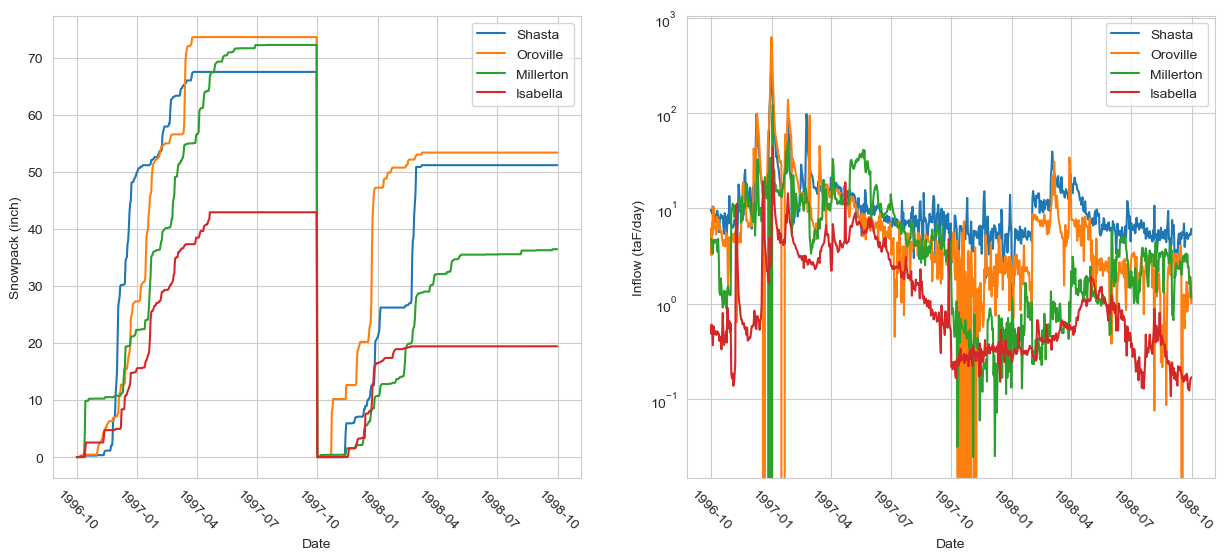

In [10]:
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax.plot(datDaily['shasta_SNPK'], label='Shasta')
ax.plot(datDaily['oroville_SNPK'], label='Oroville')
ax.plot(datDaily['millerton_SNPK'], label='Millerton')
ax.plot(datDaily['isabella_SNPK'], label='Isabella')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Snowpack (inch)')
t = plt.xticks(rotation=315)

ax = plt.subplot(122)
ax.plot(datDaily['shasta_Q'], label='Shasta')
ax.plot(datDaily['oroville_Q'], label='Oroville')
ax.plot(datDaily['millerton_Q'], label='Millerton')
ax.plot(datDaily['isabella_Q'], label='Isabella')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Inflow (taF/day)')
ax.set_yscale('log')
t = plt.xticks(rotation=315)

Additionally, we can look at model outputs such as reservoir storage and pumping from the Delta:

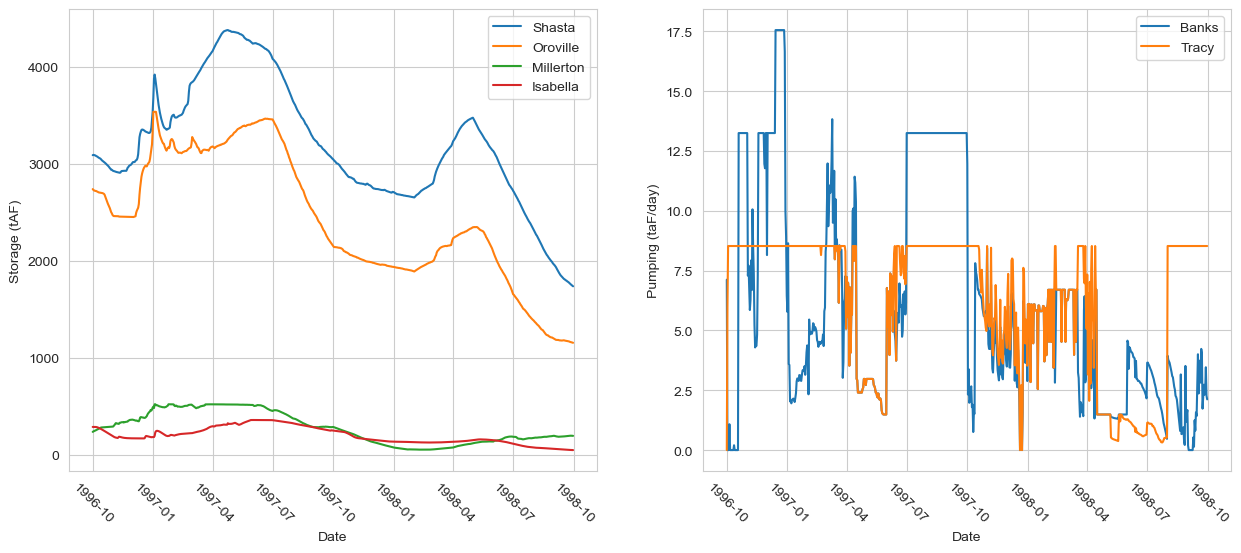

In [11]:
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax.plot(datDaily['shasta_S'], label='Shasta')
ax.plot(datDaily['oroville_S'], label='Oroville')
ax.plot(datDaily['millerton_S'], label='Millerton')
ax.plot(datDaily['isabella_S'], label='Isabella')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Storage (tAF)')
t = plt.xticks(rotation=315)

ax = plt.subplot(122)
ax.plot(datDaily['delta_HRO_pump'], label='Banks')
ax.plot(datDaily['delta_TRP_pump'], label='Tracy')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Pumping (taF/day)')
# ax.set_yscale('log')
t = plt.xticks(rotation=315)

Here is cumulative water deliveries from various sources (left) and State Water Project deliveries to various districts:

In [12]:
[c for c in datDaily.columns if 'contract' in c]

['sanluisstate_contract_flooded',
 'friant1_contract',
 'friant2_contract',
 'tableA_contract',
 'cvpdelta_contract',
 'exchange_contract',
 'kern_contract',
 'tule_contract',
 'kaweah_contract',
 'kings_contract']

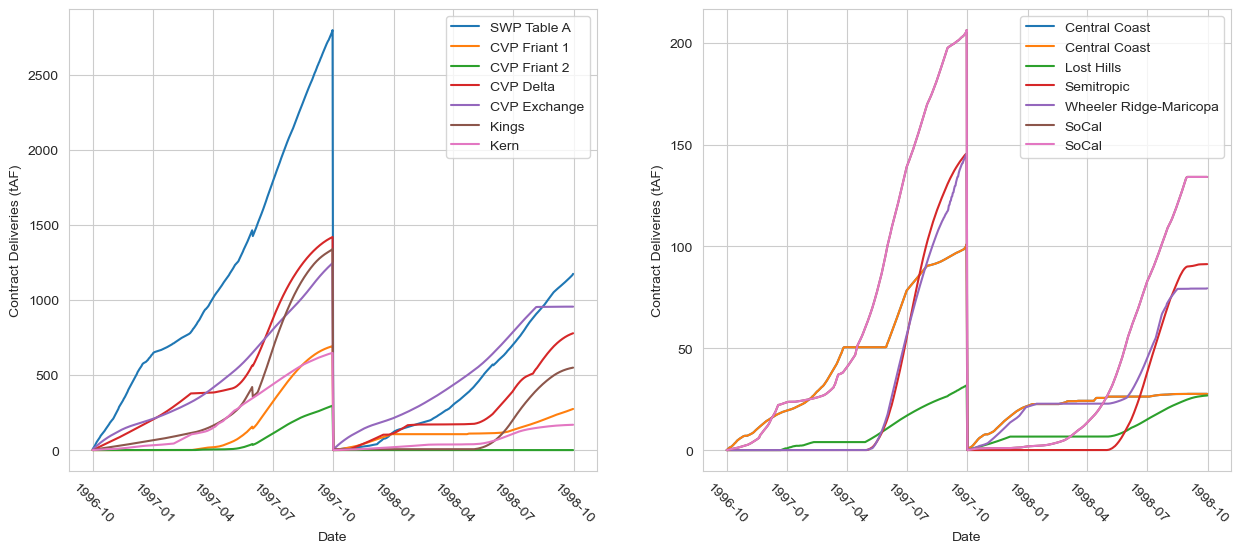

In [13]:
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax.plot(datDaily['tableA_contract'], label='SWP Table A')
ax.plot(datDaily['friant1_contract'], label='CVP Friant 1')
ax.plot(datDaily['friant2_contract'], label='CVP Friant 2')
ax.plot(datDaily['cvpdelta_contract'], label='CVP Delta')
ax.plot(datDaily['exchange_contract'], label='CVP Exchange')
ax.plot(datDaily['kings_contract'], label='Kings')
ax.plot(datDaily['kern_contract'], label='Kern')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Contract Deliveries (tAF)')
t = plt.xticks(rotation=315)

ax = plt.subplot(122)
ax.plot(datDaily['centralcoast_tableA_delivery'], label='Central Coast')
ax.plot(datDaily['losthills_tableA_delivery'], label='Lost Hills')
ax.plot(datDaily['semitropic_tableA_delivery'], label='Semitropic')
ax.plot(datDaily['wheeler_tableA_delivery'], label='Wheeler Ridge-Maricopa')
ax.plot(datDaily['socal_tableA_delivery'], label='SoCal')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Contract Deliveries (tAF)')
t = plt.xticks(rotation=315)

Lastly, we can look at recharge and recovery from the Kern Water Bank

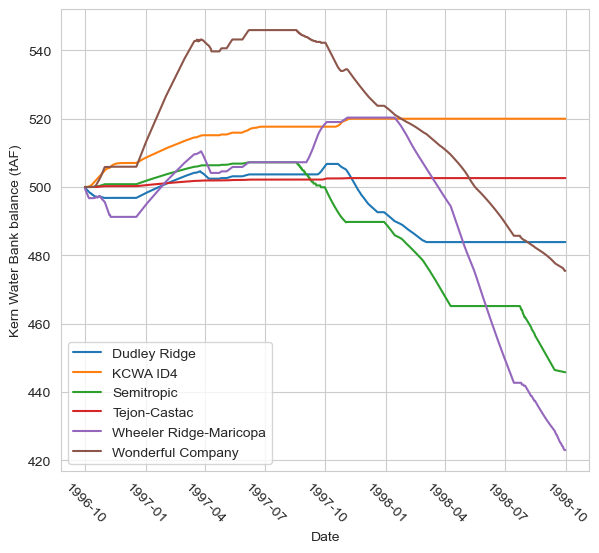

In [14]:
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax.plot(datDaily['kwb_DLR'], label='Dudley Ridge')
# ax.plot(datDaily['kwb_KCWA'], label='KCWA')
ax.plot(datDaily['kwb_ID4'], label='KCWA ID4')
ax.plot(datDaily['kwb_SMI'], label='Semitropic')
ax.plot(datDaily['kwb_TJC'], label='Tejon-Castac')
ax.plot(datDaily['kwb_WRM'], label='Wheeler Ridge-Maricopa')
ax.plot(datDaily['kwb_WON'], label='Wonderful Company')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Kern Water Bank balance (tAF)')
t = plt.xticks(rotation=315)